<a href="https://colab.research.google.com/github/fundaylncii/NaturalLanguageProcessing/blob/main/NLPCaseStudy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from wordcloud import WordCloud

In [2]:
filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width",200)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [3]:
import nltk
nltk.download("stopwords")
sw = stopwords.words("english")

nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
## AMAÇ : Ürünlere gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlar artırmayı hedeflemektedir.
## Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlenecek ve etiketlenen veri ile sınıflandırma modeli oluşturulacaktır.

In [4]:
df = pd.read_excel("/content/amazon-ksms.xlsx")

In [5]:
df.head()
## star : yıldız sayısı
## HelpFul :  yorumu faydalı bulan kişi sayısı
## Title : Yorum içeriğine verilen başlık, kısa yorum
## Review : Ürüne yapılan yorum

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [6]:
## Review değişkeninin Text Preprocessing işlemine tabi tutulması:

## Tüm harflerin küçük harfe çevrilmesi:
df["Review"] = df["Review"].str.lower()
df["Review"][0:10]


,Review
0,happy with it
1,good quality material however the panels are m...
2,product was fun for bedroom windows.<br />imag...
3,lo unico que me gustaria es que sean un poco ...
4,great bang for the buck i can't believe the qu...
5,looks different then photo
6,was exactly what i was looking for. heavy mate...
7,"looking at the picture, i thought these curtai..."
8,much whiter than i thought it would be and was...
9,these are curtains just as the picture shows. ...


In [7]:
## Noktalama işaretlerinin kaldırılması

df["Review"] = df["Review"].str.replace("[^\w\s]","", regex=True)
df["Review"][0:10]

,Review
0,happy with it
1,good quality material however the panels are m...
2,product was fun for bedroom windowsbr imagery ...
3,lo unico que me gustaria es que sean un poco ...
4,great bang for the buck i cant believe the qua...
5,looks different then photo
6,was exactly what i was looking for heavy mater...
7,looking at the picture i thought these curtain...
8,much whiter than i thought it would be and was...
9,these are curtains just as the picture shows t...


In [8]:
## Sayısal ifadelerin çıkartılması

df["Review"] = df["Review"].str.replace("\d","",regex=True)
df["Review"][0:10]

,Review
0,happy with it
1,good quality material however the panels are m...
2,product was fun for bedroom windowsbr imagery ...
3,lo unico que me gustaria es que sean un poco ...
4,great bang for the buck i cant believe the qua...
5,looks different then photo
6,was exactly what i was looking for heavy mater...
7,looking at the picture i thought these curtain...
8,much whiter than i thought it would be and was...
9,these are curtains just as the picture shows t...


In [9]:
## Bilgi içermeyen kelimelerin çıakrtılması (stopwords)

df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["Review"][0:10]

,Review
0,happy
1,good quality material however panels mismatched
2,product fun bedroom windowsbr imagery bit stre...
3,lo unico que gustaria es que sean un poco mas ...
4,great bang buck cant believe quality material ...
5,looks different photo
6,exactly looking heavy material great price shi...
7,looking picture thought curtains would thinner...
8,much whiter thought would wasnt really expecti...
9,curtains picture shows rd set ambesonne curtai...


In [10]:
## 1000 den az frekans içeren kelimelerin çıkartılması (rare words)
tmp_df = pd.Series(" ".join(df["Review"]).split()).value_counts()[-1000:]
tmp_df[0:100]

,count
keen,1
interpretation,1
greatwould,1
percect,1
nother,1
...,...
hazard,1
angle,1
designbrbrpackaging,1
tampered,1


In [11]:
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in tmp_df))
df["Review"][0:100]

,Review
0,happy
1,good quality material however panels mismatched
2,product fun bedroom windowsbr imagery bit stre...
3,lo unico que gustaria es que sean un poco mas ...
4,great bang buck cant believe quality material ...
...,...
95,first really liked product concept fabric heav...
96,ordered use backdrop halloween scene creating ...
97,bright cheery
98,bought sons galaxy themed nursery say awesome ...


In [12]:
## Lemmatization işleminin uygulanması :
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
df["Review"] = df["Review"].apply(lambda x: " ".join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))
df["Review"][0:10]

,Review
0,happy
1,good quality material however panel mismatched
2,product fun bedroom windowsbr imagery bit stre...
3,lo unico que gustaria e que sean un poco ma la...
4,great bang buck cant believe quality material ...
5,look different photo
6,exactly looking heavy material great price shi...
7,looking picture thought curtain would thinner ...
8,much whiter thought would wasnt really expecti...
9,curtain picture show rd set ambesonne curtain ...


In [14]:
## GÖRSELLEŞTİRME:
## bar plot ile görselleştirme:

## Review" kelime frekanslarının hesaplanması

tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words" , "tf"]

In [15]:
tf.head()

,words,tf
0,happy,196.00
1,good,535.00
2,quality,889.00
3,material,565.00
4,however,78.00


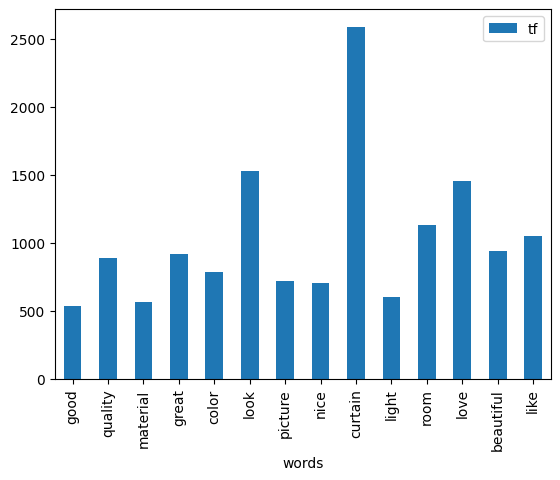

In [16]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

In [17]:
## WORLD CLOUD İLE GÖRSELLEŞTİRME:

text2 = " ".join(i for i in df.Review)
wc = WordCloud().generate(text2)

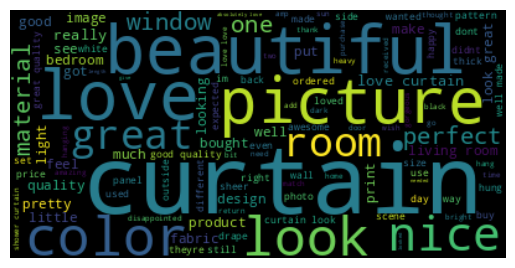

In [18]:
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [19]:
## Duygu Analizinin Gerçekleştirilmesi:

nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [20]:
sia = SentimentIntensityAnalyzer()

In [21]:
## polarite puanlarının hesaplanması:
df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])[:10]

,Review
0,0.57
1,0.44
2,0.72
3,0.00
4,0.90
5,0.00
6,0.62
7,0.91
8,0.00
9,0.71


In [22]:
## polarite değerlerinin datasete eklenmesi

df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [23]:
df.head()

,Star,HelpFul,Title,Review,polarity_score
0,5,0,looks great,happy,0.57
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,0.44
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,0.72
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,0.00
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,0.90


In [24]:
## ilk 10 değer için plarity_score <0 ise neg >0 ise pos yazdırma.

df.apply(lambda row: "pos" if row["polarity_score"] > 0 else "neg", axis=1)[:10]

,0
0,pos
1,pos
2,pos
3,neg
4,pos
5,neg
6,pos
7,pos
8,neg
9,pos


In [25]:
## her değer için label ekleme
df["polarity_label"] = df.apply(lambda x: "pos" if x["polarity_score"] > 0 else "neg", axis=1)

In [27]:
df[df["polarity_score"] > 0][0:10]

,Star,HelpFul,Title,Review,polarity_score,polarity_label
0,5,0,looks great,happy,0.57,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,0.44,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,0.72,pos
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,0.90,pos
6,5,0,Perfect for spa room,exactly looking heavy material great price shi...,0.62,pos
7,5,0,Actually better than expected,looking picture thought curtain would thinner ...,0.91,pos
9,5,0,Pretty as a Picture,curtain picture show rd set ambesonne curtain ...,0.71,pos
10,5,0,The best Christmas decoration I think I have e...,block view living room front door kitchendinin...,0.69,pos
12,5,0,They weren’t blackout curtains,dont block light,0.34,pos
15,5,24,Fun and Elegant,love curtain printed polyester type material b...,0.95,pos


In [28]:
## label değerinin encode edilmesi gerekmektedir.

df["polarity_label"] = LabelEncoder().fit_transform(df["polarity_label"])
df.head()

,Star,HelpFul,Title,Review,polarity_score,polarity_label
0,5,0,looks great,happy,0.57,1
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,0.44,1
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,0.72,1
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,0.00,0
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,0.90,1


In [31]:
df["Review"][0:10]

,Review
0,happy
1,good quality material however panel mismatched
2,product fun bedroom windowsbr imagery bit stre...
3,lo unico que gustaria e que sean un poco ma la...
4,great bang buck cant believe quality material ...
5,look different photo
6,exactly looking heavy material great price shi...
7,looking picture thought curtain would thinner ...
8,much whiter thought would wasnt really expecti...
9,curtain picture show rd set ambesonne curtain ...


In [29]:
## MAKİNE ÖĞRENMESİ HAZIRLIK:
## bağımlı - bağımsız değişken belirlenmesi, dataset train ve test olarak ayırmak
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["polarity_label"],
                                                    random_state=42)

In [36]:
## tfıdf nesnesinin oluşturulması:

tf_idf_vec = TfidfVectorizer().fit(train_x)

In [37]:
## tarin ve test için transform: (metin verilerini vektörlere dönüştürme)

x_train_tf_idf_word = tf_idf_vec.transform(train_x)
x_test_tf_idf_word = tf_idf_vec.transform(test_x)

In [40]:
## Lojistik Regresyon Model Oluşturma:

log_model = LogisticRegression(random_state=42).fit(x_train_tf_idf_word, train_y)

In [41]:
from sklearn.metrics import classification_report, accuracy_score

predictions = log_model.predict(x_test_tf_idf_word)
print(classification_report(test_y, predictions))
print("Accuracy:", accuracy_score(test_y, predictions))

              precision    recall  f1-score   support

           0       0.90      0.33      0.49       223
           1       0.89      0.99      0.94      1180

    accuracy                           0.89      1403
   macro avg       0.89      0.66      0.71      1403
weighted avg       0.89      0.89      0.87      1403

Accuracy: 0.8880969351389879


In [42]:
## corss val:
cross_val_score(log_model, x_train_tf_idf_word, train_y, cv=5).mean()

0.8826058221605884

In [44]:
## dataset içerisinden rastgele bir yorum seçtik
new_review = pd.Series(df["Review"].sample(n=1).iloc[0])
print(new_review)

0    great artwork easy install blackout curtain me...
dtype: object


In [45]:
## yorumu vektörleştirdik
new_review = tf_idf_vec.transform(new_review)

In [46]:
## model predict denemesi:

log_model.predict(new_review)

array([1])

In [47]:
## kendi oluşturduğumuz yorumun denemesi:
new_review2= "this is a bad product"
new_review2 = tf_idf_vec.transform([new_review2])
log_model.predict(new_review2)

array([0])

In [48]:
## Random Forest İle model:

rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
predictions = rf_model.predict(x_test_tf_idf_word)
print(classification_report(test_y, predictions))
print("Accuracy:", accuracy_score(test_y, predictions))

              precision    recall  f1-score   support

           0       0.80      0.57      0.66       223
           1       0.92      0.97      0.95      1180

    accuracy                           0.91      1403
   macro avg       0.86      0.77      0.81      1403
weighted avg       0.90      0.91      0.90      1403

Accuracy: 0.9087669280114041


In [49]:
## Hiperparametre optimizasyonu :

rf_model2 = RandomForestClassifier(random_state=42)
rf_params = {"max_depth": [8,None],
             "max_features":[7,"auto"],
             "min_samples_split":[2,5,8],
             "n_estimators":[100,200]}

In [50]:
rf_best_grid = GridSearchCV(rf_model2, rf_params, cv=5, n_jobs=-1, verbose=1).fit(x_train_tf_idf_word,train_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [51]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=45).fit(x_train_tf_idf_word,train_y)

In [52]:
## hiperparametre op. sonrasında model aşırı öğrenme yaptığı için Accuracy oranı düşüyor. Bu nedenle rf_model kullanılması daha doğru.
predictions = rf_final.predict(x_test_tf_idf_word)
print(classification_report(test_y, predictions))
print("Accuracy:", accuracy_score(test_y, predictions))

              precision    recall  f1-score   support

           0       0.84      0.40      0.55       223
           1       0.90      0.99      0.94      1180

    accuracy                           0.89      1403
   macro avg       0.87      0.69      0.74      1403
weighted avg       0.89      0.89      0.88      1403

Accuracy: 0.8930862437633642


In [53]:
cross_val_score(rf_final, x_train_tf_idf_word,train_y, cv=5, n_jobs=-1).mean()

0.9082708911741196